<a href="https://colab.research.google.com/github/HKamilya/spotify-data-analysis/blob/main/spotify_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект "Анализ тональности и предсказание настроения музыки"

Анализ тональности - это метод анализа текста, который определяет полярность (например, положительное или отрицательное мнение) в тексте, будь то весь документ, абзац, предложение или пункт.

Анализ настроений направлен на измерение отношения, настроений, оценок, отношений и эмоций оратора / писателя на основе вычислительной обработки субъективности в тексте. 

# 1.Цели

Научиться работать и использовать NTLK для анализа тональности текстов

# 2.Установка и подготовка необходимых библиотек

In [ ]:
!pip install lyricsgenius

In [ ]:
! pip install spotipy

In [ ]:
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import json
import csv
import pylyrics3
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
from spotipy.oauth2 import SpotifyClientCredentials
import lyricwikia
import lyricsgenius as lg

import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

import scikitplot.plotters as skplt
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifierCV

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    roc_curve, 
    auc,
    classification_report
)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


#3.Подготовка данных

NTLK - ведущая платформа для создания программ Python для работы с данными на человеческом языке. 

Установим словарь vader_lexicon. Как он выглядит:

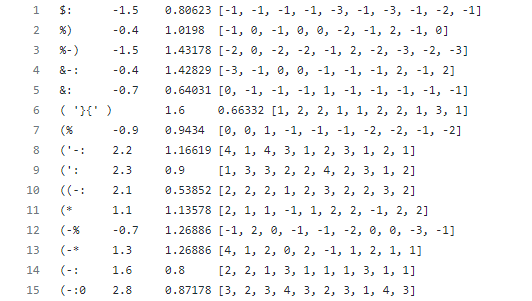

*   Колонка 1: Токен
*   Колонка 2: Это среднее значение рейтинга настроений людей. 
*   Колонка 3: Это стандартное отклонение токена при условии, что он соответствует нормальному распределению
*   Колонка 4: Это список из 10 оценок человека, полученных в ходе экспериментов. 

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 3.1 Сбор данных из сервиса Spotify

In [ ]:
cid = '437a6bebdc8d410ab84cf4c6c3feb05d'
secret = '42a25e7a16554ca2b1070de096230a3a'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sentiment_analyzer = SIA()

In [ ]:
api_key = "YUkRrA30Ei-wHoH73w6nhzcIxZAMvc9FEL79l4ooUkAMHmvf-oRFYsYCwSx4Cag1"
genius = lg.Genius(api_key, skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], remove_section_headers=True)

In [ ]:
def get_features(track_id):
    features_results = sp.audio_features([track_id])
    json_features = json.dumps(features_results)
    features_data = json.loads(json_features)

    # Convert features dictionary to a list
    features_list = list(features_data[0].values())

    return features_list

In [ ]:
playlist_ids = [
    "37i9dQZEVXbNG2KDcFcKOF",
    "37i9dQZEVXbK4fwx2r07XW",
    "37i9dQZEVXbK8BKKMArIyl",
    "37i9dQZEVXbNALwC1jxb5m",
    "37i9dQZEVXbLp5XoPON0wI",
    "37i9dQZEVXbNcoJZ65xktI",
    "37i9dQZEVXbKx6qX9uN66j",
    "37i9dQZEVXbN66FupT0MuX",
    "37i9dQZEVXbMZ5PAcNTDXd",
    "37i9dQZEVXbK4BFAukDzj3",
    "37i9dQZEVXbMda2apknTqH",
    "37i9dQZEVXbM1EaZ0igDlz",
    "37i9dQZEVXbND4ZYa46PaA",
    "37i9dQZEVXbKzoK95AbRy9",
    "37i9dQZEVXbMwmF30ppw50",
    "37i9dQZEVXbKZyn1mKjmIl",
    "37i9dQZEVXbJHSzlHx2ZJU",
    "37i9dQZEVXbMdvweCgpBAe"
]
feature_names = [
  "danceability",
  "energy",
  "key",
  "loudness",
  "mode",
  "speechiness",
  "acousticness",
  "instrumentalness",
  "liveness",
  "valence",
  "tempo",
  "type",
  "id",
  "uri",
  "track_href",
  "analysis_url",
  "duration_ms",
  "time_signature"
]

в playlist_id находятся id топ чартов разных стран

Вытащим также слова текстов песен, а с помощью библиотеки NTLK произведем анализ их настроения 

In [ ]:
writer.writerow(['track_id', 'playlist_id', 'date_added', 'track_name', 'first_artist'] + feature_names + ['lyrics', 'neg', 'neu', 'pos', 'compound'])
for playlist_id in playlist_ids:
    print('Querying playlist: ' + str(playlist_id))

    repeat_query = True
    offset_n = 0
    for i in range(2):
       
        if i > 0:
            print('Repeating query')
            offset_n += 100
        results = sp.playlist_tracks(playlist_id, offset=offset_n)
        json_results = json.dumps(results)
        data = json.loads(json_results)

       
        for track in data['items']:
            track_id = track['track']['id']
            date_added = track['added_at']
            track_name = track['track']['name']
            first_artist = track['track']['artists'][0]['name']

           
            features = get_features(track_id)

            
            lyrics = ''
            try:
                lyrics = genius.search_song(track_name, first_artist )
                
            except:
                pass

        
            neg = None
            neu = None
            pos = None
            compound = None
            if lyrics:
                snt = sentiment_analyzer.polarity_scores(lyrics.lyrics)
                neg = snt['neg']
                neu = snt['neu']
                pos = snt['pos']
                compound = snt['compound']

            writer.writerow([track_id, playlist_id, date_added, track_name, first_artist] + features + [lyrics] + [neg, neu, pos, compound])

      
        if data['total'] < 100:
            break

    print('Done querying')

data_file.close()

Querying playlist: 37i9dQZEVXbNG2KDcFcKOF
Searching for "abcdefu" by GAYLE...
Done.
Searching for "STAY (with Justin Bieber)" by The Kid LAROI...
Done.
Searching for "All I Want for Christmas Is You" by Mariah Carey...
Done.
Searching for "Easy On Me" by Adele...
Done.
Searching for "INDUSTRY BABY (feat. Jack Harlow)" by Lil Nas X...
Done.
Searching for "Last Christmas" by Wham!...
Done.
Searching for "Heat Waves" by Glass Animals...
Done.
Searching for "Enemy (with JID) - from the series Arcane League of Legends" by Imagine Dragons...
Done.
Searching for "Cold Heart - PNAU Remix" by Elton John...
Done.
Searching for "Rockin' Around The Christmas Tree" by Brenda Lee...
Done.
Searching for "Jingle Bell Rock" by Bobby Helms...
Done.
Searching for "It's Beginning to Look a Lot like Christmas" by Michael Bublé...
Done.
Searching for "Shivers" by Ed Sheeran...
Done.
Searching for "Santa Tell Me" by Ariana Grande...
Done.
Searching for "Pepas" by Farruko...
Done.
Searching for "Bad Habits" b

### 3.2 Собранные признаки

**danceability** - танцевальность описывает, насколько трек подходит для танцев на основе комбинации музыкальных элементов, включая темп, стабильность ритма, силу удара и общую регулярность. Значение 0.0 наименее танцевально, а 1.0 - наиболее танцевально.

**energy** - энергия оценивается от 0.0 до 1.0 и представляет собой меру интенсивности и активности. Обычно энергичные треки кажутся быстрыми, громкими и шумными. Характеристики восприятия, влияющие на этот атрибут, включают динамический диапазон, воспринимаемую громкость, тембр, скорость начала.

**key** - ключ, в котором находится трек. Целые числа отображаются на высоту тона с использованием стандартной нотации Pitch Class . Например, 0 = C, 1 = C♯ / D ♭, 2 = D и так далее. Если ключ не обнаружен, значение равно -1. Максимальное значение = 11.

**loudness** - общая громкость трека в децибелах (дБ). Обычно значения находятся в диапазоне от -60 до 0 дБ.

**mode** - указывает модальность (мажор или минор) трека, тип гаммы, из которой получено его мелодическое содержание. Мажор представлен 1, а второстепенный - 0.

**speechiness** - определяет наличие произнесенных слов в дорожке. Чем более похожа на речь запись (например, ток-шоу, аудиокнига, стихи), тем ближе значение атрибута к 1,0.

**acousticness** - мера достоверности того, является ли трек акустическим. 1.0 означает высокую степень уверенности в том, что трек акустический. Измеряется от 0,0 до 1,0

**instrumentalness** - определяет, будет ли дорожка содержать вокал. Чем ближе значение инструментальности к 1.0, тем больше вероятность, что трек не содержит вокального содержания.

**liveness** - обнаруживает присутствие аудитории в записи. Более высокие значения живучести представляют повышенную вероятность того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек был в прямом эфире.

**valence** - мера от 0,0 до 1,0, описывающая музыкальную позитивность, передаваемую треком. Треки с высокой валентностью звучат более позитивно (счастливые, веселые, эйфорические), а треки с низкой валентностью - более негативные (грустные, подавленные, сердитые).

**tempo** - общий оценочный темп трека в ударах в минуту (BPM). В музыкальной терминологии темп - это скорость или темп данной пьесы, производный непосредственно от средней продолжительности такта.

**duration_ms** - продолжительность трека в миллисекундах.

**time_signature** - это условное обозначение, определяющее количество ударов в каждом такте. Размер варьируется от 3 до 7, указывая размер от «3/4» до «7/4».

## 3.3 Загрузка данных

In [ ]:
data_file = open('data.csv','w')
writer = csv.writer(data_file)

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data.head()

,track_id,playlist_id,date_added,track_name,first_artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,lyrics,neg,neu,pos,compound
0,4fouWK6XVHhzl78KzQ1UjL,37i9dQZEVXbNG2KDcFcKOF,2021-12-17T16:34:22Z,abcdefu,GAYLE,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.0,0.3670,0.415,121.932,audio_features,4fouWK6XVHhzl78KzQ1UjL,spotify:track:4fouWK6XVHhzl78KzQ1UjL,https://api.spotify.com/v1/tracks/4fouWK6XVHhz...,https://api.spotify.com/v1/audio-analysis/4fou...,168602,4,"""​abcdefu"" by GAYLE:\n Fuck you and your mo...",0.192,0.712,0.096,-0.9912
1,5PjdY0CKGZdEuoNab3yDmX,37i9dQZEVXbNG2KDcFcKOF,2021-12-17T16:34:22Z,STAY (with Justin Bieber),The Kid LAROI,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.0,0.1030,0.478,169.928,audio_features,5PjdY0CKGZdEuoNab3yDmX,spotify:track:5PjdY0CKGZdEuoNab3yDmX,https://api.spotify.com/v1/tracks/5PjdY0CKGZdE...,https://api.spotify.com/v1/audio-analysis/5Pjd...,141806,4,"""New Music Friday 7/9/21"" by Spotify:\n BTS...",0.114,0.798,0.089,-0.8947
2,0bYg9bo50gSsH3LtXe2SQn,37i9dQZEVXbNG2KDcFcKOF,2021-12-17T16:34:22Z,All I Want for Christmas Is You,Mariah Carey,0.336,0.627,7,-7.463,1,0.0384,0.1640,0.0,0.0708,0.350,150.273,audio_features,0bYg9bo50gSsH3LtXe2SQn,spotify:track:0bYg9bo50gSsH3LtXe2SQn,https://api.spotify.com/v1/tracks/0bYg9bo50gSs...,https://api.spotify.com/v1/audio-analysis/0bYg...,241107,4,"""All I Want for Christmas Is You"" by Mariah Ca...",0.089,0.833,0.079,0.9230
3,46IZ0fSY2mpAiktS3KOqds,37i9dQZEVXbNG2KDcFcKOF,2021-12-17T16:34:22Z,Easy On Me,Adele,0.604,0.366,5,-7.519,1,0.0282,0.5780,0.0,0.1330,0.130,141.981,audio_features,46IZ0fSY2mpAiktS3KOqds,spotify:track:46IZ0fSY2mpAiktS3KOqds,https://api.spotify.com/v1/tracks/46IZ0fSY2mpA...,https://api.spotify.com/v1/audio-analysis/46IZ...,224695,4,"""Easy On Me"" by Adele:\n There ain't no gol...",0.036,0.783,0.181,0.9798
4,5Z9KJZvQzH6PFmb8SNkxuk,37i9dQZEVXbNG2KDcFcKOF,2021-12-17T16:34:22Z,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,0.741,0.691,10,-7.395,0,0.0672,0.0221,0.0,0.0476,0.892,150.087,audio_features,5Z9KJZvQzH6PFmb8SNkxuk,spotify:track:5Z9KJZvQzH6PFmb8SNkxuk,https://api.spotify.com/v1/tracks/5Z9KJZvQzH6P...,https://api.spotify.com/v1/audio-analysis/5Z9K...,212353,4,"""INDUSTRY BABY"" by Lil Nas X & Jack Harlow:\n ...",0.033,0.809,0.159,0.9966


In [ ]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,neg,neu,pos,compound
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,844.000000,844.000000,844.000000,844.000000
mean,0.654738,0.616628,5.130000,-7.046649,0.692222,0.092395,0.325774,0.008031,0.189034,0.560205,126.854892,194845.824444,3.942222,0.061263,0.833688,0.105110,0.174095
std,0.145981,0.176641,3.654091,2.700803,0.461831,0.093883,0.275660,0.063556,0.144919,0.231565,31.606123,55406.755288,0.307481,0.059786,0.112293,0.095918,0.822740
min,0.234000,0.077400,0.000000,-20.617000,0.000000,0.023100,0.000214,0.000000,0.026000,0.039200,67.196000,91268.000000,1.000000,0.000000,0.436000,0.000000,-0.999900
25%,0.574500,0.500750,2.000000,-8.506750,0.000000,0.036850,0.071100,0.000000,0.092800,0.384250,101.016000,160699.750000,4.000000,0.012000,0.752000,0.013750,-0.838275
50%,0.677000,0.627000,5.000000,-6.900000,1.000000,0.050200,0.274000,0.000000,0.126500,0.555000,124.927000,190087.000000,4.000000,0.043000,0.822000,0.096000,0.458800
75%,0.761000,0.764000,8.000000,-5.044000,1.000000,0.094850,0.509000,0.000020,0.293250,0.732500,149.975250,224695.000000,4.000000,0.095000,0.943250,0.159000,0.986800
max,0.975000,0.939000,11.000000,-1.322000,1.000000,0.588000,0.958000,0.843000,0.977000,0.972000,205.958000,643200.000000,5.000000,0.340000,1.000000,0.500000,0.999800


## 3.4 Очистка данных

In [ ]:
data.columns.values

array(['track_id', 'playlist_id', 'date_added', 'track_name',
       'first_artist', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'lyrics', 'neg',
       'neu', 'pos', 'compound'], dtype=object)

In [ ]:
data.drop_duplicates(subset=['track_id'], keep='first', inplace=True)

In [ ]:
data.dtypes

track_id             object
playlist_id          object
date_added           object
track_name           object
first_artist         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
lyrics               object
neg                 float64
neu                 float64
pos                 float64
compound            float64
dtype: object

In [ ]:
data.size

12404

In [ ]:
data.drop(['track_id', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'lyrics'], axis=1, inplace=True)

# 4.Визуализация

## 4.1 Респределение 

In [ ]:
data_plot = data.select_dtypes(include=[np.number]).dropna()

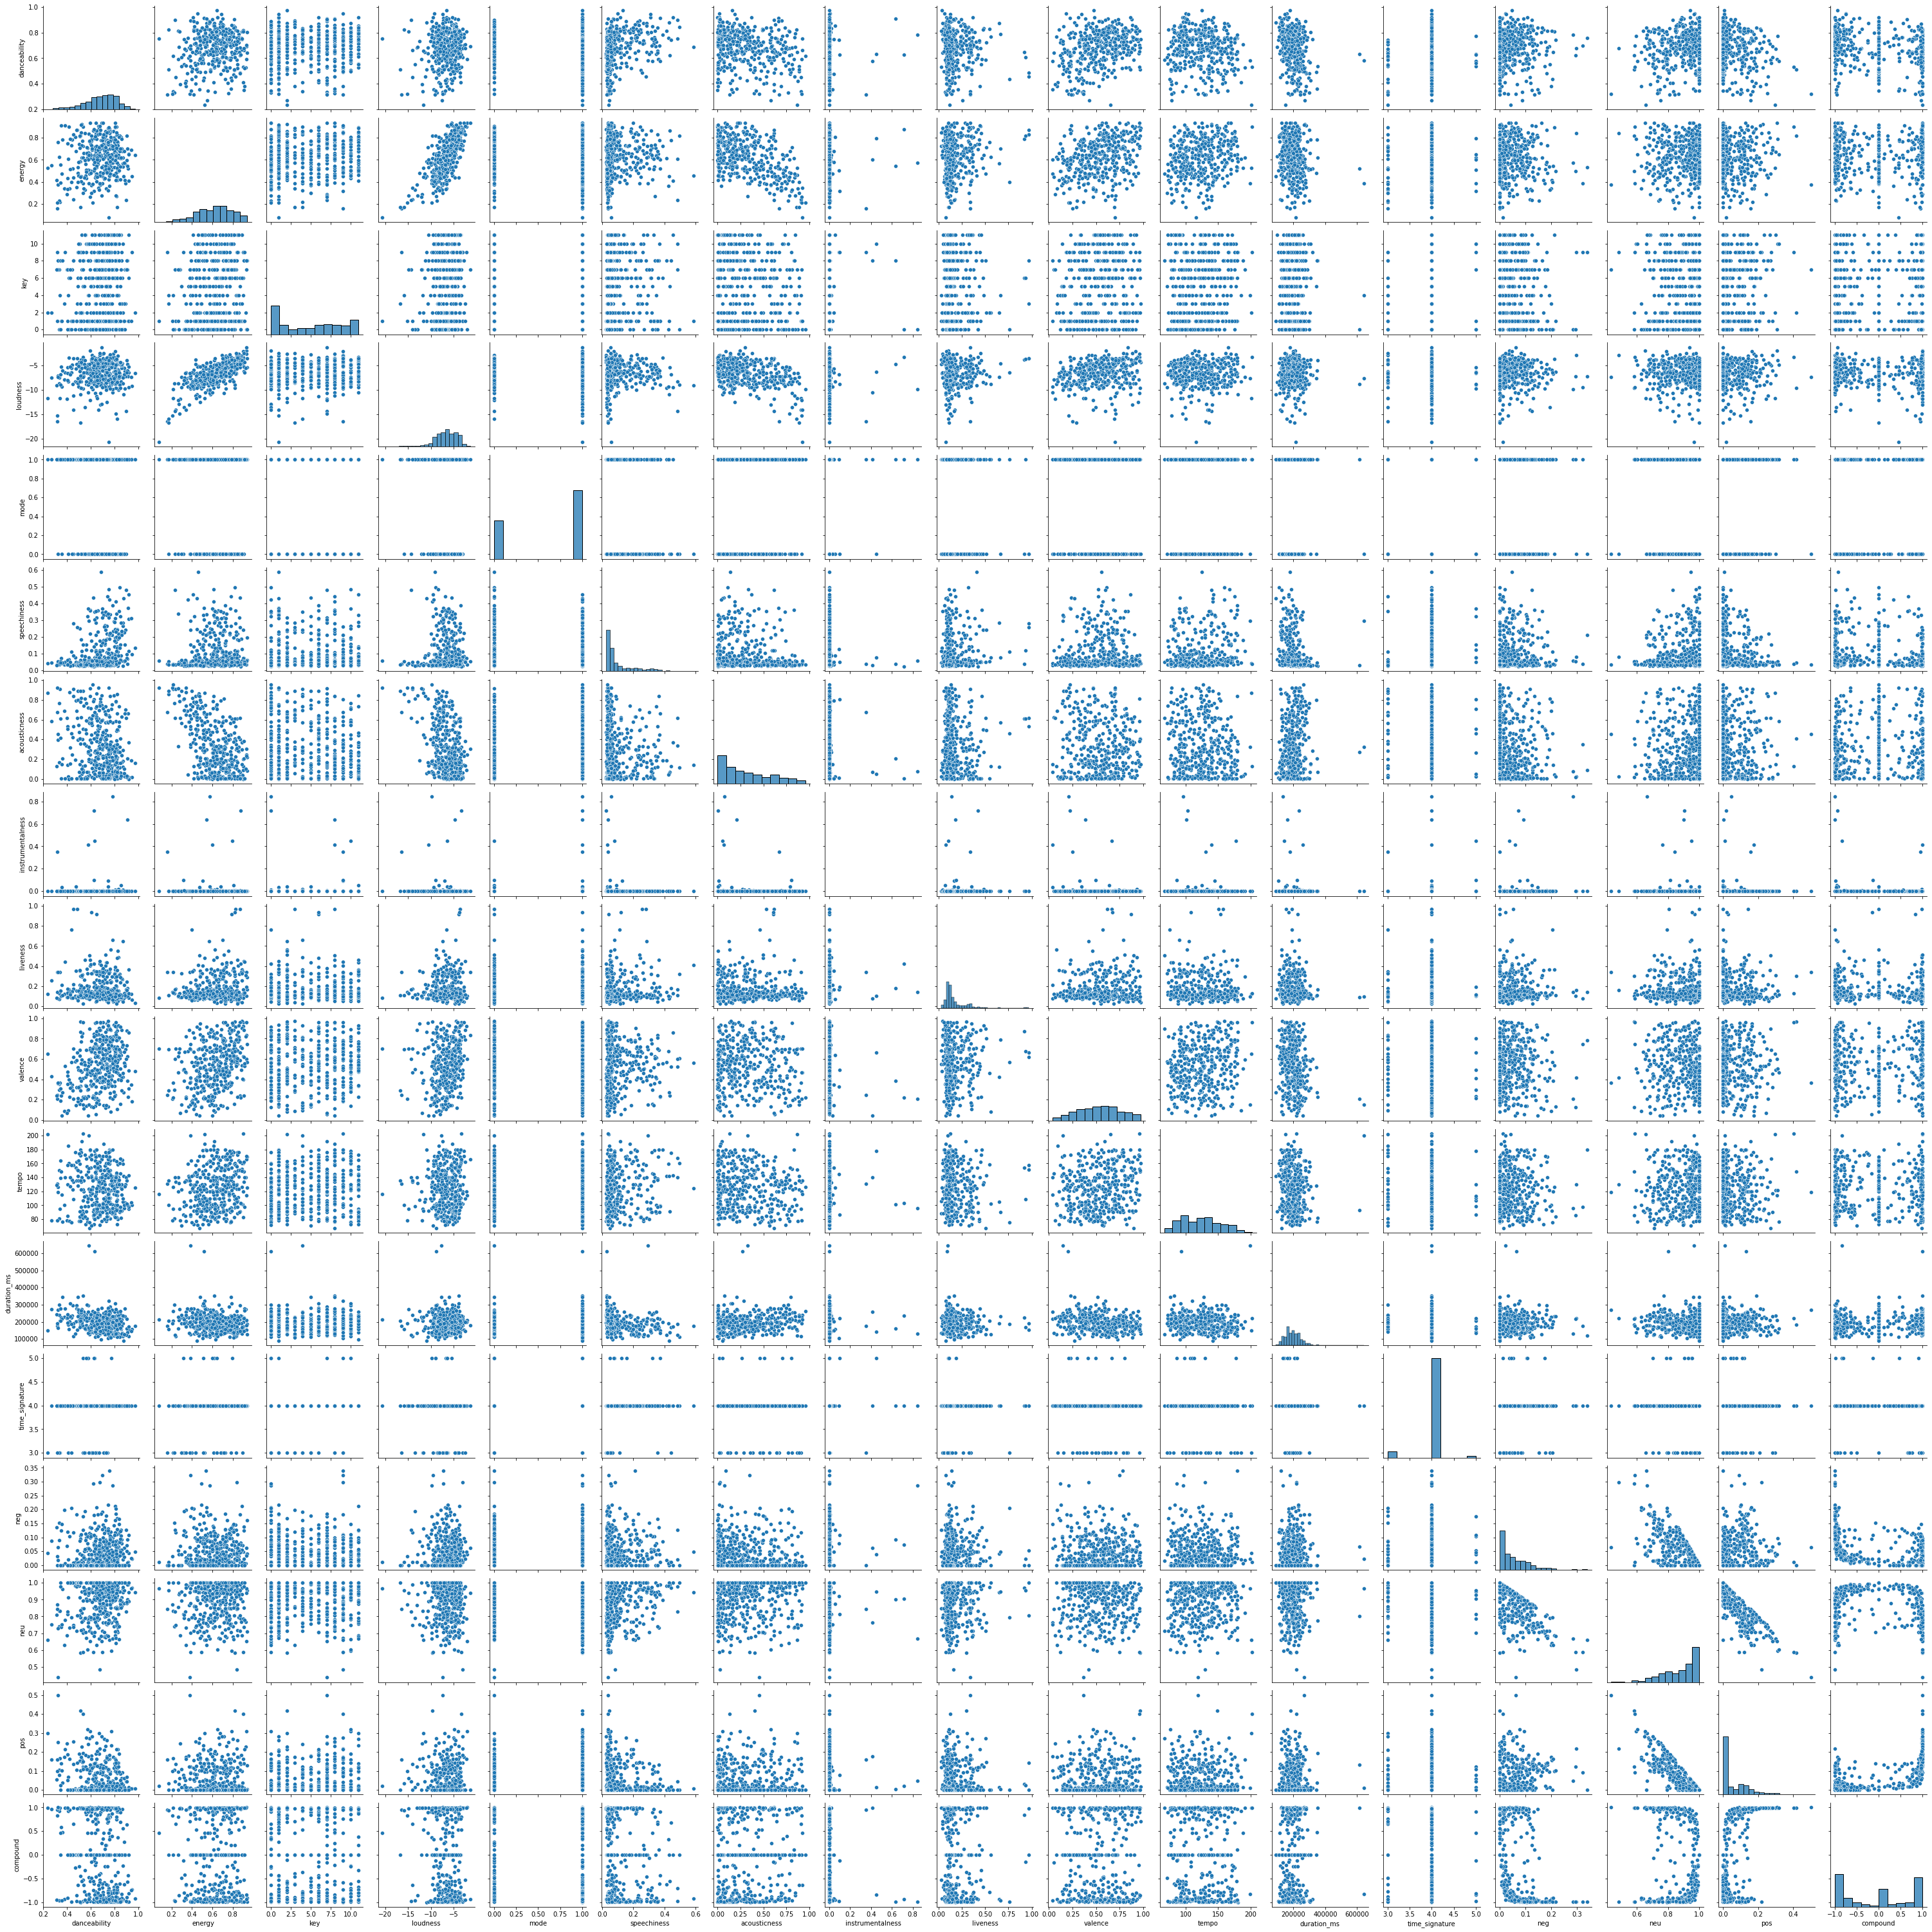

In [ ]:
sns.pairplot(data_plot)

ValueError: ignored

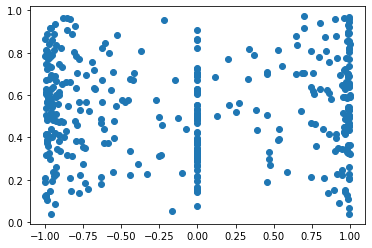

In [ ]:
x = data['compound']
y = data['valence']
plt.scatter(x, y)

reg = np.polyfit(x,y,1)
trendline = np.poly1d(reg)

plt.plot(x,trendline(x),'r--')

## 4.2 Оценка корреляции

In [ ]:
data.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,neg,neu,pos,compound
danceability,1.000000,0.148178,0.046288,0.145911,-0.211787,0.319290,-0.243435,0.006742,-0.085457,0.329907,-0.079802,-0.328583,0.123275,0.049226,0.166348,-0.257957,-0.233898
energy,0.148178,1.000000,0.100949,0.729103,-0.151019,0.074954,-0.585365,-0.004834,0.152292,0.341667,0.198413,-0.183237,0.130268,-0.026907,-0.011822,0.034879,0.005735
key,0.046288,0.100949,1.000000,0.089793,-0.195881,0.016404,-0.050079,0.000376,-0.015205,0.076933,0.071019,0.017727,0.073418,-0.053643,0.001601,0.036084,0.043923
loudness,0.145911,0.729103,0.089793,1.000000,-0.086929,0.006650,-0.441119,-0.047785,0.096926,0.223536,0.068580,-0.064167,0.038052,0.062534,-0.055838,0.030154,-0.068267
mode,-0.211787,-0.151019,-0.195881,-0.086929,1.000000,-0.212667,0.050817,0.050491,-0.019083,-0.091168,-0.074413,0.087474,-0.044872,-0.038467,-0.035132,0.074379,0.083481
speechiness,0.319290,0.074954,0.016404,0.006650,-0.212667,1.000000,-0.186135,-0.070304,0.043610,0.031872,0.124243,-0.221146,0.094374,-0.004323,0.130491,-0.171691,-0.161280
acousticness,-0.243435,-0.585365,-0.050079,-0.441119,0.050817,-0.186135,1.000000,-0.075378,0.008217,-0.085538,-0.098682,0.154516,-0.110599,-0.152193,0.109572,-0.038952,0.060881
instrumentalness,0.006742,-0.004834,0.000376,-0.047785,0.050491,-0.070304,-0.075378,1.000000,0.022797,-0.131278,-0.025538,-0.042040,0.029668,0.131132,-0.055298,-0.019344,-0.079506
liveness,-0.085457,0.152292,-0.015205,0.096926,-0.019083,0.043610,0.008217,0.022797,1.000000,0.095490,-0.009845,-0.077317,-0.024428,-0.009797,-0.002219,0.009791,-0.000970
valence,0.329907,0.341667,0.076933,0.223536,-0.091168,0.031872,-0.085538,-0.131278,0.095490,1.000000,0.171836,-0.271612,-0.029993,-0.033282,0.011724,0.007992,0.022410


In [ ]:
normalized = Normalizer().fit_transform(data_plot)

norm_df = pd.DataFrame(normalized)
norm_df.columns = data_plot.columns
norm_corr = norm_df.corr()

norm_corr

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,neg,neu,pos,compound
danceability,1.000000,0.626398,0.278730,-0.448840,0.142100,0.512609,-0.012723,0.069367,0.214466,0.595428,0.594028,-0.571844,0.850138,0.190769,0.817257,-0.053578,-0.185266
energy,0.626398,1.000000,0.278635,0.002214,0.094056,0.311553,-0.252634,0.032420,0.317458,0.582822,0.612685,-0.582636,0.699014,0.104882,0.641401,0.073431,-0.059165
key,0.278730,0.278635,1.000000,-0.085174,-0.126918,0.117643,-0.031328,0.022135,0.072154,0.274615,0.277064,-0.262770,0.302426,0.034925,0.260314,0.060292,-0.011941
loudness,-0.448840,0.002214,-0.085174,1.000000,-0.186612,-0.334663,-0.382631,-0.101423,-0.115810,-0.219558,-0.410279,0.426660,-0.554460,-0.073548,-0.537771,-0.048187,-0.024301
mode,0.142100,0.094056,-0.126918,-0.186612,1.000000,-0.030493,0.028617,0.075963,0.037411,0.115561,0.113521,-0.107634,0.214085,0.024601,0.195823,0.113002,0.047765
speechiness,0.512609,0.311553,0.117643,-0.334663,-0.030493,1.000000,-0.051882,-0.050045,0.185578,0.203284,0.397047,-0.407953,0.465082,0.054827,0.475704,-0.118470,-0.158375
acousticness,-0.012723,-0.252634,-0.031328,-0.382631,0.028617,-0.051882,1.000000,-0.064863,0.078361,0.127410,0.072863,-0.074835,0.110098,-0.075726,0.117562,0.094167,0.127328
instrumentalness,0.069367,0.032420,0.022135,-0.101423,0.075963,-0.050045,-0.064863,1.000000,0.029962,-0.072698,0.035705,-0.034824,0.093999,0.212186,0.034336,-0.022341,-0.117502
liveness,0.214466,0.317458,0.072154,-0.115810,0.037411,0.185578,0.078361,0.029962,1.000000,0.235458,0.227191,-0.221666,0.299626,0.063759,0.286568,0.034797,-0.043878
valence,0.595428,0.582822,0.274615,-0.219558,0.115561,0.203284,0.127410,-0.072698,0.235458,1.000000,0.549748,-0.533105,0.581962,0.109176,0.544046,0.095238,0.003560


In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    
    plt.xticks(rotation=70)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

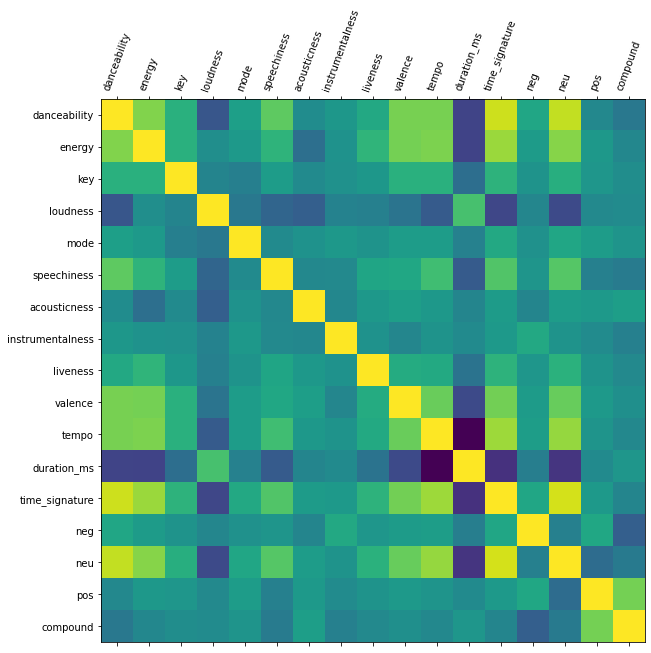

In [ ]:
plot_corr(norm_df)

In [ ]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(norm_df, 20))

Top Absolute Correlations
tempo           duration_ms       0.978241
time_signature  neu               0.871365
danceability    time_signature    0.850138
                neu               0.817257
tempo           time_signature    0.712789
energy          time_signature    0.699014
duration_ms     time_signature    0.697783
tempo           neu               0.688993
duration_ms     neu               0.676354
energy          neu               0.641401
danceability    energy            0.626398
energy          tempo             0.612685
danceability    valence           0.595428
                tempo             0.594028
pos             compound          0.588499
energy          valence           0.582822
                duration_ms       0.582636
valence         time_signature    0.581962
danceability    duration_ms       0.571844
loudness        time_signature    0.554460
dtype: float64


In [ ]:
def get_top_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Correlations")
print(get_top_correlations(norm_df, 20))

Top Correlations
time_signature  neu               0.871365
danceability    time_signature    0.850138
                neu               0.817257
tempo           time_signature    0.712789
energy          time_signature    0.699014
tempo           neu               0.688993
energy          neu               0.641401
danceability    energy            0.626398
energy          tempo             0.612685
danceability    valence           0.595428
                tempo             0.594028
pos             compound          0.588499
energy          valence           0.582822
valence         time_signature    0.581962
                tempo             0.549748
                neu               0.544046
danceability    speechiness       0.512609
speechiness     neu               0.475704
                time_signature    0.465082
loudness        duration_ms       0.426660
dtype: float64


In [ ]:
def get_bottom_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print("Bottom Correlations")
print(get_bottom_correlations(norm_df, 20))

Bottom Correlations
tempo         duration_ms      -0.978241
duration_ms   time_signature   -0.697783
              neu              -0.676354
energy        duration_ms      -0.582636
danceability  duration_ms      -0.571844
loudness      time_signature   -0.554460
              neu              -0.537771
valence       duration_ms      -0.533105
danceability  loudness         -0.448840
loudness      tempo            -0.410279
speechiness   duration_ms      -0.407953
loudness      acousticness     -0.382631
neg           compound         -0.381815
loudness      speechiness      -0.334663
neu           pos              -0.275755
key           duration_ms      -0.262770
energy        acousticness     -0.252634
liveness      duration_ms      -0.221666
loudness      valence          -0.219558
              mode             -0.186612
dtype: float64


## 4.3 Анализ настроения треков

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Compound')

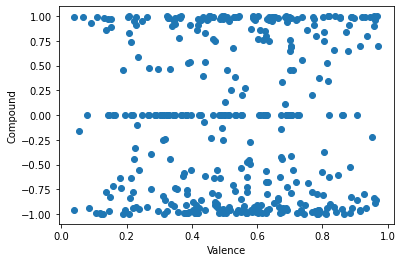

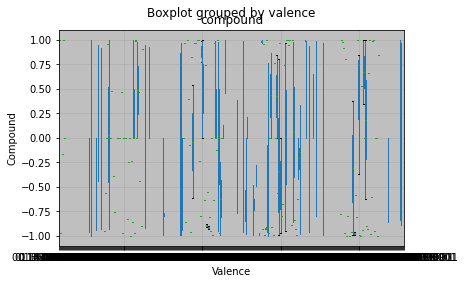

In [ ]:
x = data['valence']
y = data['compound']

reg = np.polyfit(x,y,1)
trendline = np.poly1d(reg)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x,trendline(x),'r--')
ax.set_xlabel('Valence')
ax.set_ylabel('Compound')

box = data.boxplot('compound','valence')
box.set_xlabel('Valence')
box.set_ylabel('Compound')

# 5.Предсказание настроения треков

## 5.1 Добавление новых признаков

In [ ]:
data_numerical = data.select_dtypes(include=[np.number])

In [ ]:
data_numerical.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,neg,neu,pos,compound
0,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.0,0.3670,0.415,121.932,168602,4,0.192,0.712,0.096,-0.9912
1,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.0,0.1030,0.478,169.928,141806,4,0.114,0.798,0.089,-0.8947
2,0.336,0.627,7,-7.463,1,0.0384,0.1640,0.0,0.0708,0.350,150.273,241107,4,0.089,0.833,0.079,0.9230
3,0.604,0.366,5,-7.519,1,0.0282,0.5780,0.0,0.1330,0.130,141.981,224695,4,0.036,0.783,0.181,0.9798
4,0.741,0.691,10,-7.395,0,0.0672,0.0221,0.0,0.0476,0.892,150.087,212353,4,0.033,0.809,0.159,0.9966


In [ ]:
train_data = data_numerical.dropna(inplace=False)

In [ ]:
train_data.drop(['neg','neu','pos'], axis=1, inplace=True)

In [ ]:
train_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,compound
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.678090,0.622644,5.010000,-6.73313,0.640000,0.108830,0.317082,0.009806,0.176921,0.535018,123.986345,196864.655000,3.960000,-0.057874
std,0.138388,0.171466,3.627367,2.54836,0.480601,0.106773,0.264159,0.072871,0.136672,0.225407,29.862645,54797.885983,0.271264,0.780408
min,0.234000,0.077400,0.000000,-20.61700,0.000000,0.023100,0.000214,0.000000,0.026000,0.039200,67.196000,91268.000000,3.000000,-0.999900
25%,0.598750,0.506750,1.000000,-8.19750,0.000000,0.039375,0.085475,0.000000,0.098400,0.365250,98.758250,162644.750000,4.000000,-0.894950
50%,0.696000,0.635000,5.000000,-6.51800,1.000000,0.057800,0.261000,0.000000,0.124500,0.540000,123.016500,192539.000000,4.000000,0.000000
75%,0.774750,0.753500,8.000000,-4.79750,1.000000,0.136000,0.509000,0.000036,0.202500,0.701000,145.003500,225720.750000,4.000000,0.858800
max,0.975000,0.939000,11.000000,-1.32200,1.000000,0.588000,0.958000,0.843000,0.970000,0.972000,202.899000,643200.000000,5.000000,0.999800


In [ ]:
norm_corr.loc['compound'].sort_values(ascending=False)

compound            1.000000
pos                 0.588499
acousticness        0.127328
duration_ms         0.059574
mode                0.047765
valence             0.003560
key                -0.011941
loudness           -0.024301
liveness           -0.043878
tempo              -0.054483
energy             -0.059165
time_signature     -0.080090
instrumentalness   -0.117502
speechiness        -0.158375
neu                -0.159455
danceability       -0.185266
neg                -0.381815
Name: compound, dtype: float64

In [ ]:
norm_corr.loc['compound'].abs().sort_values(ascending=False)

compound            1.000000
pos                 0.588499
neg                 0.381815
danceability        0.185266
neu                 0.159455
speechiness         0.158375
acousticness        0.127328
instrumentalness    0.117502
time_signature      0.080090
duration_ms         0.059574
energy              0.059165
tempo               0.054483
mode                0.047765
liveness            0.043878
loudness            0.024301
key                 0.011941
valence             0.003560
Name: compound, dtype: float64

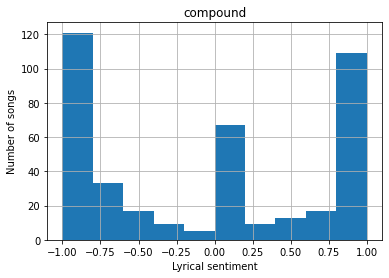

In [ ]:
hist = train_data.hist(column='compound', bins=10)
for h in hist.flatten():
    h.set_xlabel('Lyrical sentiment')
    h.set_ylabel('Number of songs')

In [ ]:
train_data['sentiment'] = np.where(train_data['compound']>0, 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,compound,sentiment
0,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.0,0.3670,0.415,121.932,168602,4,-0.9912,0
1,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.0,0.1030,0.478,169.928,141806,4,-0.8947,0
2,0.336,0.627,7,-7.463,1,0.0384,0.1640,0.0,0.0708,0.350,150.273,241107,4,0.9230,1
3,0.604,0.366,5,-7.519,1,0.0282,0.5780,0.0,0.1330,0.130,141.981,224695,4,0.9798,1
4,0.741,0.691,10,-7.395,0,0.0672,0.0221,0.0,0.0476,0.892,150.087,212353,4,0.9966,1


In [ ]:
train_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,compound,sentiment
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.678090,0.622644,5.010000,-6.73313,0.640000,0.108830,0.317082,0.009806,0.176921,0.535018,123.986345,196864.655000,3.960000,-0.057874,0.375000
std,0.138388,0.171466,3.627367,2.54836,0.480601,0.106773,0.264159,0.072871,0.136672,0.225407,29.862645,54797.885983,0.271264,0.780408,0.484729
min,0.234000,0.077400,0.000000,-20.61700,0.000000,0.023100,0.000214,0.000000,0.026000,0.039200,67.196000,91268.000000,3.000000,-0.999900,0.000000
25%,0.598750,0.506750,1.000000,-8.19750,0.000000,0.039375,0.085475,0.000000,0.098400,0.365250,98.758250,162644.750000,4.000000,-0.894950,0.000000
50%,0.696000,0.635000,5.000000,-6.51800,1.000000,0.057800,0.261000,0.000000,0.124500,0.540000,123.016500,192539.000000,4.000000,0.000000,0.000000
75%,0.774750,0.753500,8.000000,-4.79750,1.000000,0.136000,0.509000,0.000036,0.202500,0.701000,145.003500,225720.750000,4.000000,0.858800,1.000000
max,0.975000,0.939000,11.000000,-1.32200,1.000000,0.588000,0.958000,0.843000,0.970000,0.972000,202.899000,643200.000000,5.000000,0.999800,1.000000


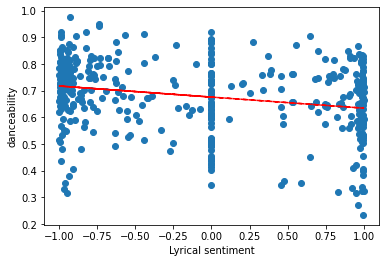

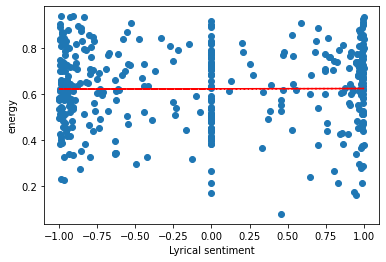

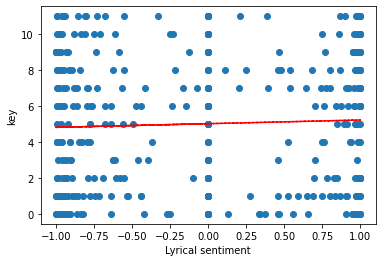

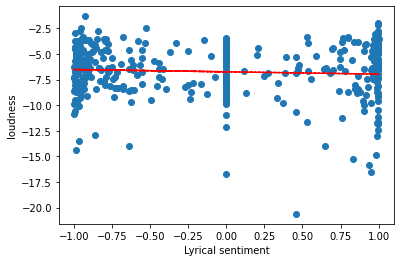

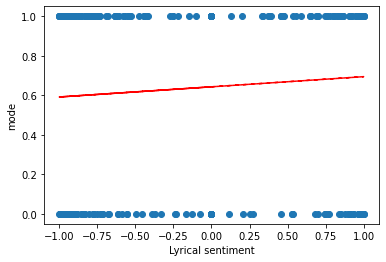

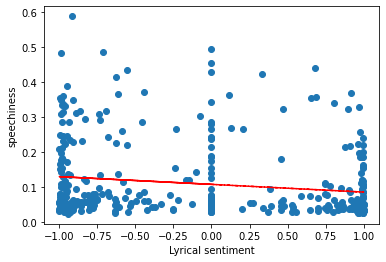

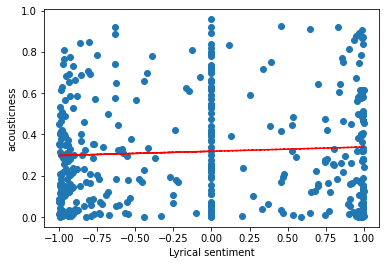

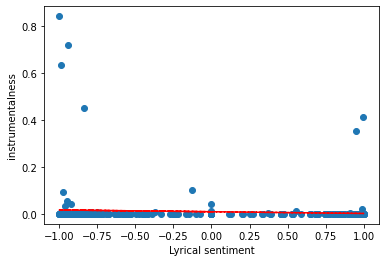

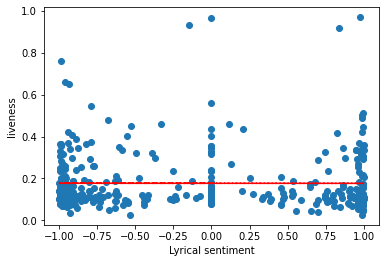

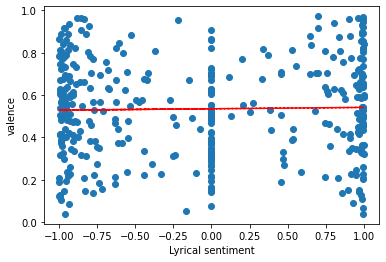

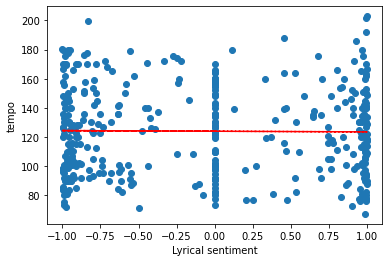

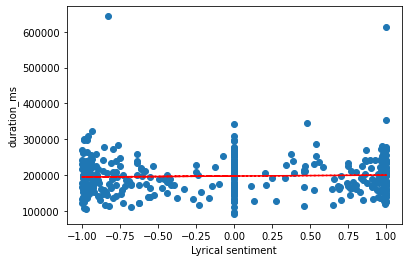

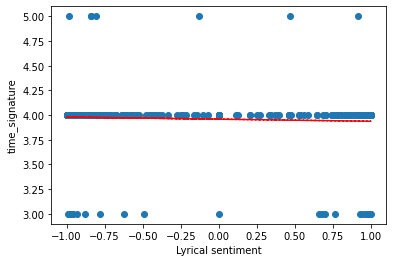

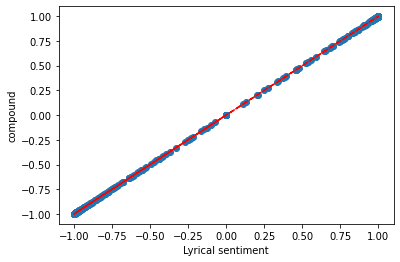

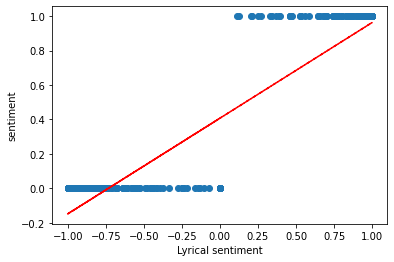

In [ ]:
for col in train_data:
    try:
        x = train_data['compound']
        y = train_data[col]

        # Calculate trendline
        reg = np.polyfit(x,y,1)
        trendline = np.poly1d(reg)

        # Scatterplot with trendline
        fig, ax = plt.subplots()
        ax.scatter(x, y)
        ax.plot(x,trendline(x),'r--')
        ax.set_xlabel('Lyrical sentiment')
        ax.set_ylabel(col)
    except:
        print(col)

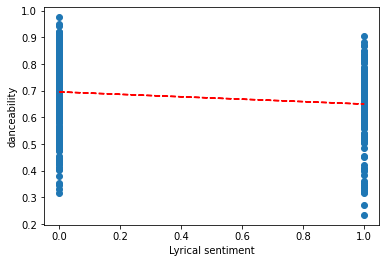

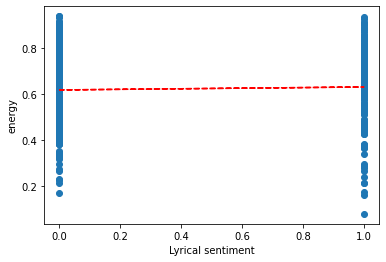

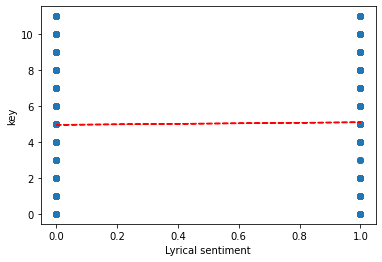

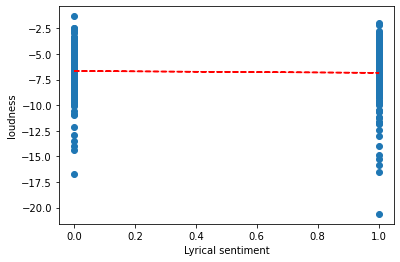

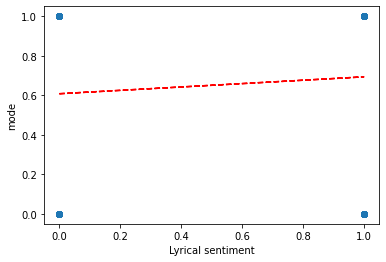

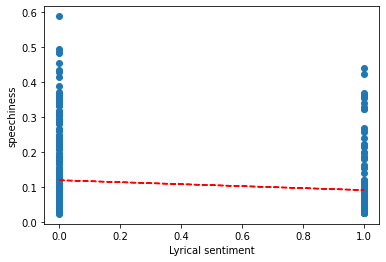

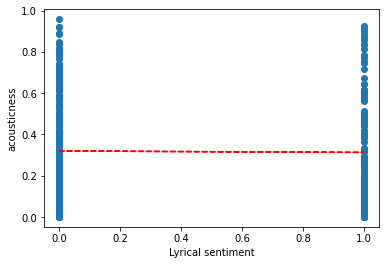

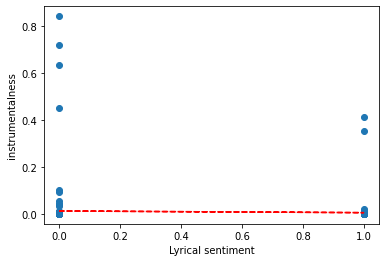

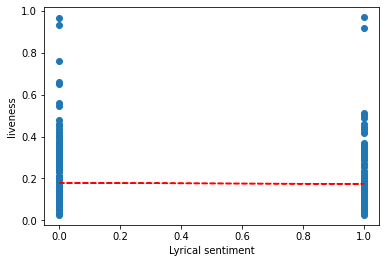

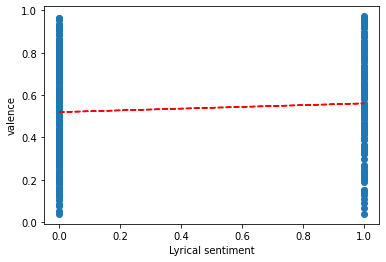

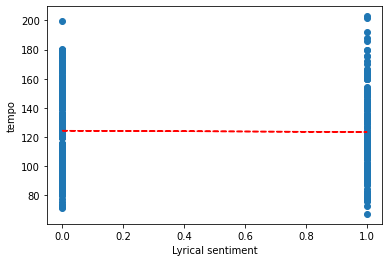

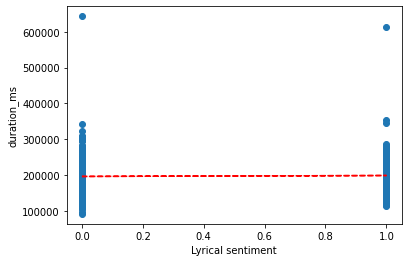

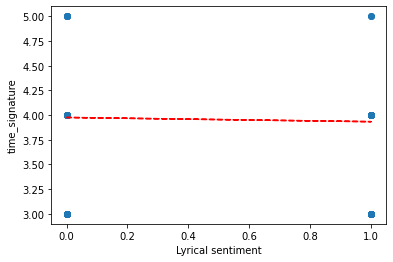

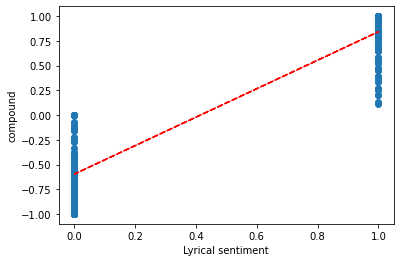

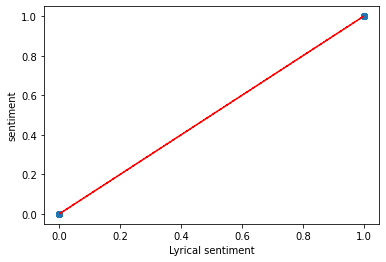

In [ ]:
for col in train_data:
    try:
        x = train_data['sentiment']
        y = train_data[col]

        # Calculate trendline
        reg = np.polyfit(x,y,1)
        trendline = np.poly1d(reg)

        # Scatterplot with trendline
        fig, ax = plt.subplots()
        ax.scatter(x, y)
        ax.plot(x,trendline(x),'r--')
        ax.set_xlabel('Lyrical sentiment')
        ax.set_ylabel(col)
    except:
        print(col)

In [ ]:
y = train_data['sentiment']
y.head()

0    0
1    0
2    1
3    1
4    1
Name: sentiment, dtype: int64

In [ ]:
X = train_data.drop(['compound','sentiment'], axis=1, inplace=False)
X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.0,0.3670,0.415,121.932,168602,4
1,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.0,0.1030,0.478,169.928,141806,4
2,0.336,0.627,7,-7.463,1,0.0384,0.1640,0.0,0.0708,0.350,150.273,241107,4
3,0.604,0.366,5,-7.519,1,0.0282,0.5780,0.0,0.1330,0.130,141.981,224695,4
4,0.741,0.691,10,-7.395,0,0.0672,0.0221,0.0,0.0476,0.892,150.087,212353,4


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y , test_size=0.3, random_state=42)

***Model assessment***

In [ ]:
def assess_model(clf):
    # Assess model 
    results = clf.predict(test_x)
    
    # Accuracy
    try:
        accuracy = accuracy_score(test_y, results)
        print("Accuracy score: ", accuracy)
    except:
        accuracy = accuracy_score(test_y, results.round())
        print("Accuracy score: ", accuracy)
    
    # Precision
    try:
        precision = precision_score(test_y, results)
        print("Precision score: ", precision)
    except:
        precision = precision_score(test_y, results.round())
        print("Precision score: ", precision)
    
    # AUC
    try:
        fpr, tpr, thresholds = roc_curve(test_y, results) 
        auc_score = auc(fpr, tpr)
        print("AUC: ", auc_score)
    except:
        fpr, tpr, thresholds = roc_curve(test_y, results.round()) 
        auc_score = auc(fpr, tpr)
        print("AUC: ", auc_score)
       # Report
    try:
        report = classification_report(test_y, results)
        print("Classification report: ", report)
    except:
        report = classification_report(test_y, results.round())
        print("Classification report: ", report)

In [ ]:
!pip install scikit-plot

In [ ]:
def plot_confusion_matrix(clf):
    results = clf.predict(test_x)
    skplt.plot_confusion_matrix(test_y, results,
                            normalize=True,
                            title='Confusion matrix')

In [ ]:
def plot_roc(clf):
    fpr, tpr, _ = roc_curve(y_true=test_y,
                            y_score=[x[1] for x in clf.predict_proba(test_x)],
                            pos_label=1)

    classifier_name = clf.__class__.__name__
    if hasattr(clf, 'steps'):
        classifier_name = clf.steps[-1][-1].__class__.__name__

    plt.plot(fpr, tpr, label='{} AUC = {}'.format(
        classifier_name,
        round(roc_auc_score(y_true=test_y,
                            y_score=[x[1] for x in clf.predict_proba(test_x)]), 2)))

    plt.plot([0, 1], [0, 1], '--', color='black', label='Random Guess')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

In [ ]:
def feature_importance(clf):
    feature_importances = pd.DataFrame({'feature_name': X.columns.values,
                                        'feature_importance': clf.feature_importances_})

    feature_importances.sort_values('feature_importance', ascending=True).plot(kind='barh',
                                                                           figsize=(10, 10),
                                                                           y='feature_importance',
                                                                           x='feature_name',
                                                                           legend=False,
                                                                           title='Lyrical Sentiment: Audio Feature Importances')
    plt.ylabel('')

## 5.2 Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier() 
dt.fit(train_x, train_y)

DecisionTreeClassifier()

In [ ]:
assess_model(dt)

Accuracy score:  0.575
Precision score:  0.4358974358974359
AUC:  0.5361339600470034
Classification report:                precision    recall  f1-score   support

           0       0.64      0.70      0.67        74
           1       0.44      0.37      0.40        46

    accuracy                           0.57       120
   macro avg       0.54      0.54      0.54       120
weighted avg       0.56      0.57      0.57       120



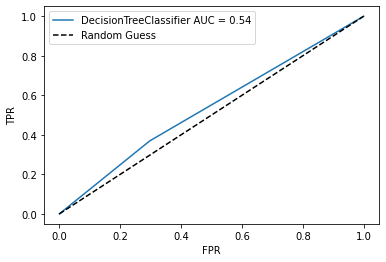

In [ ]:
plot_roc(dt)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


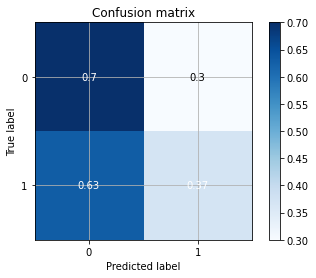

In [ ]:
plot_confusion_matrix(dt)

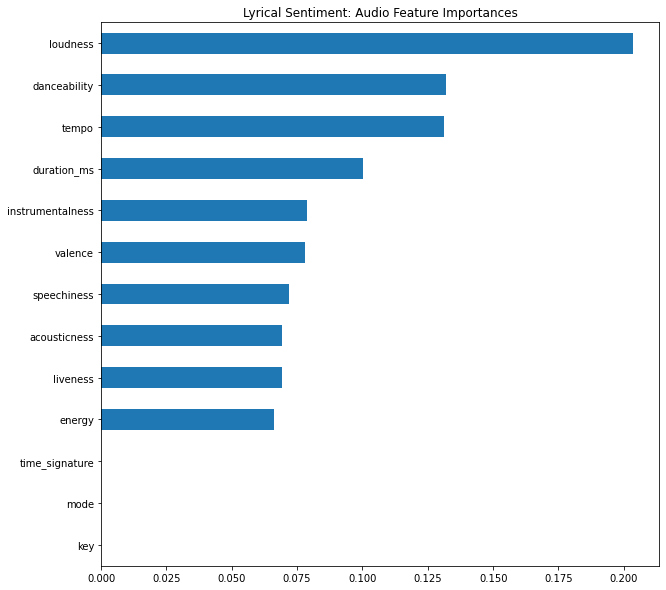

In [ ]:
feature_importance(dt)

## 5.3 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(train_x, train_y)

RandomForestClassifier()

In [ ]:
assess_model(rf)

Accuracy score:  0.675
Precision score:  0.6666666666666666
AUC:  0.604876615746181
Classification report:                precision    recall  f1-score   support

           0       0.68      0.91      0.77        74
           1       0.67      0.30      0.42        46

    accuracy                           0.68       120
   macro avg       0.67      0.60      0.60       120
weighted avg       0.67      0.68      0.64       120



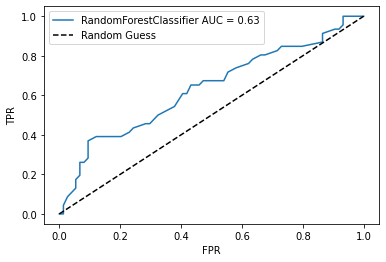

In [ ]:
plot_roc(rf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


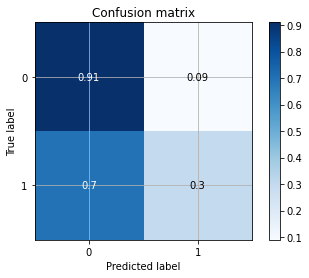

In [ ]:
plot_confusion_matrix(rf)

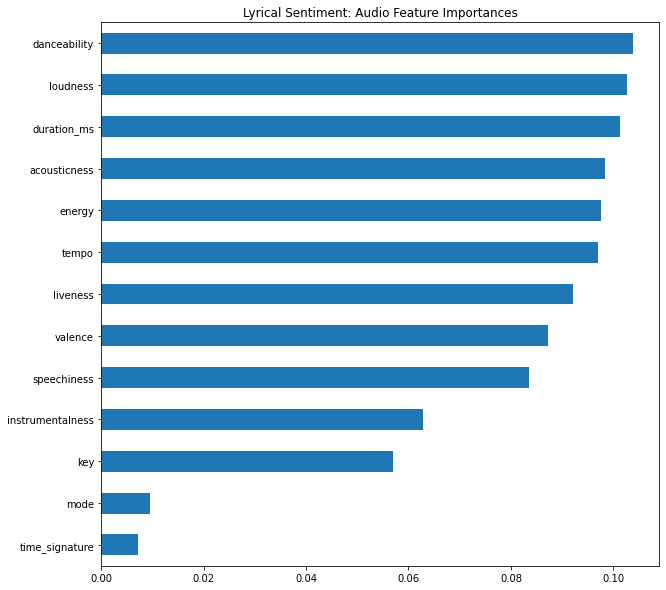

In [ ]:
feature_importance(rf)

6.4 Gradient Boosting Classifier

In [ ]:
boost = GradientBoostingClassifier()
boost.fit(train_x, train_y)

GradientBoostingClassifier()

In [ ]:
assess_model(boost)

Accuracy score:  0.5583333333333333
Precision score:  0.3870967741935484
AUC:  0.5020564042303173
Classification report:                precision    recall  f1-score   support

           0       0.62      0.74      0.67        74
           1       0.39      0.26      0.31        46

    accuracy                           0.56       120
   macro avg       0.50      0.50      0.49       120
weighted avg       0.53      0.56      0.54       120



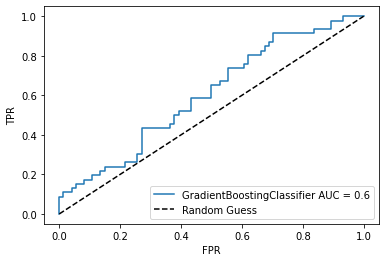

In [ ]:
plot_roc(boost)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


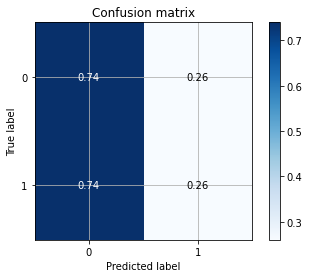

In [ ]:
plot_confusion_matrix(boost)

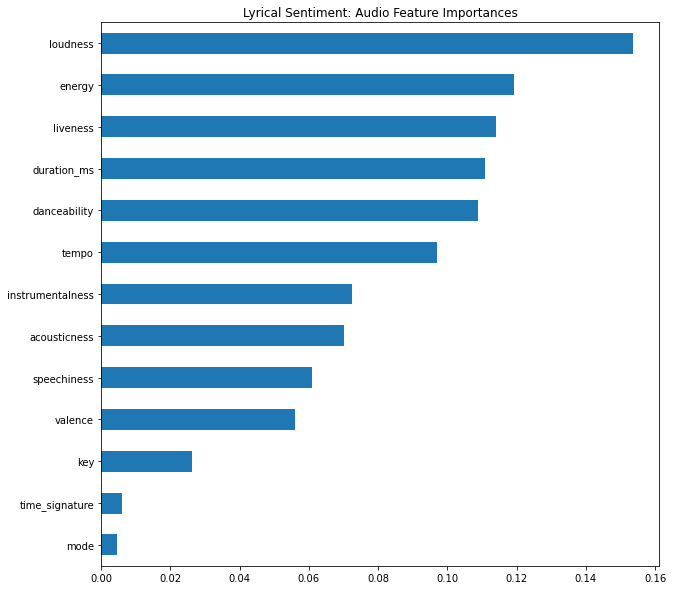

In [ ]:
feature_importance(boost)

## 5.4 Linnear Regression

In [ ]:
reg = LinearRegression()
reg.fit(train_x, train_y)

LinearRegression()

In [ ]:
reg_results = reg.predict(test_x)
accuracy = accuracy_score(test_y, reg_results.round())
print(accuracy)

0.6833333333333333


In [ ]:
print(reg_results.round())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
assess_model(reg)

Accuracy score:  0.6833333333333333
Precision score:  0.7857142857142857
AUC:  0.7021151586368979
Classification report:                precision    recall  f1-score   support

           0       0.67      0.96      0.79        74
           1       0.79      0.24      0.37        46

    accuracy                           0.68       120
   macro avg       0.73      0.60      0.58       120
weighted avg       0.71      0.68      0.63       120



## 5.5 Ridge Classifier with Cross Validation

In [ ]:
ridge = RidgeClassifierCV()
ridge.fit(train_x, train_y)

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))

In [ ]:
assess_model(ridge)

Accuracy score:  0.625
Precision score:  1.0
AUC:  0.5108695652173914
Classification report:                precision    recall  f1-score   support

           0       0.62      1.00      0.77        74
           1       1.00      0.02      0.04        46

    accuracy                           0.62       120
   macro avg       0.81      0.51      0.40       120
weighted avg       0.77      0.62      0.49       120



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


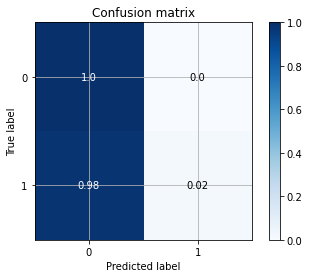

In [ ]:
plot_confusion_matrix(ridge)

# 6.Полезные ссылки

* https://www.kaggle.com/nadintamer/what-makes-top-spotify-songs-popular - по Спотифаю
*   https://www.youtube.com/watch?v=YczTyXIuW-o - лекция ФКН ВШЭ по рекомендательным системам 2020-2021 года 
*   https://www.youtube.com/watch?v=rCTBa-IaAf4&list=PLEqoHzpnmTfDwuwrFHWVHdr1-qJsfqCUX&index=11 - лекция ФКН ВШЭ по рекомендательным системам 2018-2019 года
*   http://wiki.cs.hse.ru/%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_2 - конспекты лекций Соколова

